## **Surrogate modelling to design a digital twin for ground source heat exchangers**

Author: Emilio Osuna

Data exploration is done in `data_exploration.ipynb`

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src import heat_transfer_pinn

In [2]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

CUDA is available!
Number of GPUs: 1
Current GPU: Quadro M2000M


The purpose of this notebook is to perform the simulations of a surrogate model based on [Yildiz & Stirling, 2022](https://doi.org/10.1016/j.geothermics.2022.102351), where a finite difference model is used to predict soil temperature.

The governing PDE model is a transient heat conduction equation:

\begin{equation}
    \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial z^2} + \frac{\partial \alpha}{\partial z} \frac{\partial T}{\partial z}
\end{equation}


The thermal diffusivity $\alpha$ changes over time and space. The upper temperature measured at the top of the lysimeter is consider as the boundary condition (Dirichlet). The heat flux at the lower boundary is calculated by adding the measured heat flux at 940 mm depth, and the energy stored in the soil layer between 850 mm and 940 mm:

\begin{equation}
    \Delta S = \int_{z=850}^{z=940} C \frac{\partial T}{\partial t} \, dz + \int_{z=850}^{z=940} T \frac{\partial C}{\partial t} \, dz
\end{equation}

As the hydrological regime of the soil is fluctuating throughout the field-testing period, a relationship between the volumetric water content ($\theta$) and the thermal property in question is needed:

\begin{equation}
\alpha_{\text{sand}} = 0.25 + \frac{0.64}{1 + e^{-1.72(\theta - 6.01)}}
\end{equation}

\begin{equation}
\alpha_{\text{topsoil}} = 0.23 + \frac{0.25}{1 + e^{-0.78(\theta - 11.3)}}
\end{equation}

\begin{equation}
C_{\text{sand}} = 296.4 + \frac{52.7 + 8.32(\theta - 5.27)}{1 + e^{-3.24(\theta - 5.27)}}
\end{equation}

## PINN Model

The model is trained in and save for testing in `heat_transfer_pinn.py`.

In [3]:
df = pd.read_csv("data/processed/merged_data_interpolated.csv", parse_dates=["Time"])
df["time_s"] = (df["Time"] - df["Time"].min()).dt.total_seconds()
df["z_m"] = df["Height"] / 1000.0

t_data = torch.tensor(df["time_s"].values, dtype=torch.float32).reshape(-1,1)
z_data = torch.tensor(df["z_m"].values, dtype=torch.float32).reshape(-1,1)
theta_data = torch.tensor(df["VWC"].values, dtype=torch.float32).reshape(-1,1)

t_mean, t_std = t_data.mean(), t_data.std()
z_mean, z_std = z_data.mean(), z_data.std()
theta_mean, theta_std = theta_data.mean(), theta_data.std()

df_test = pd.read_csv("data/processed/test_data.csv", parse_dates=["Time"])
df_test["time_s"] = (df_test["Time"] - df_test["Time"].min()).dt.total_seconds()
df_test["z_m"] = df_test["Height"] / 1000.0

t_data_test = torch.tensor(df_test["time_s"].values, dtype=torch.float32).reshape(-1,1)
z_data_test = torch.tensor(df_test["z_m"].values, dtype=torch.float32).reshape(-1,1)
theta_data_test = torch.tensor(df_test["VWC"].values, dtype=torch.float32).reshape(-1,1)
T_measured_data_test = torch.tensor(df_test["SoilTemp"].values, dtype=torch.float32).reshape(-1,1)

model_test = heat_transfer_pinn.PINN(num_hidden_layers=4, num_neurons=64,
                                    t_mean=t_mean, t_std=t_std,
                                    z_mean=z_mean, z_std=z_std,
                                    theta_mean=theta_mean, theta_std=theta_std)
model_test.load_state_dict(torch.load("pinn_model.pth"))
model_test.eval() 

PINN(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (activation): Tanh()
)

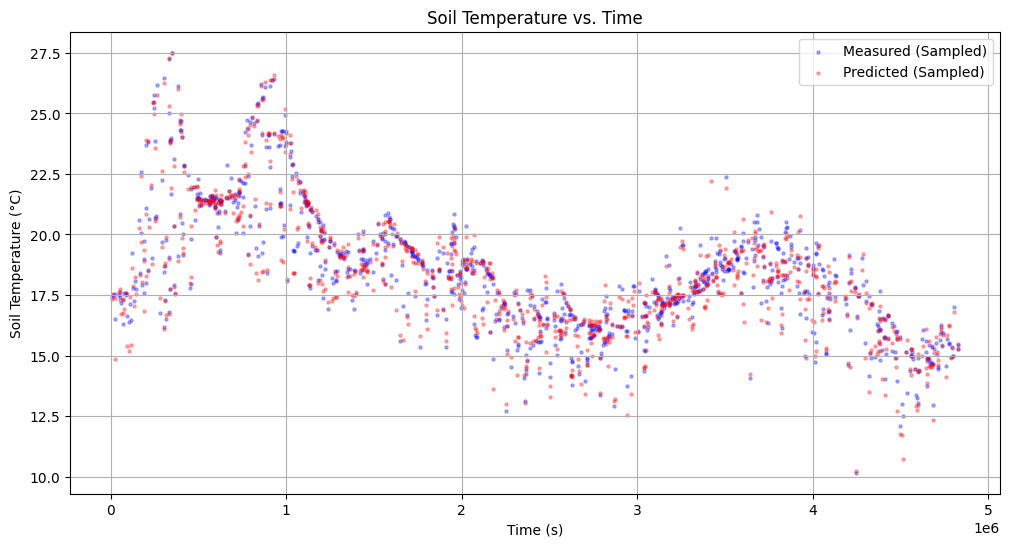

In [4]:
with torch.no_grad():
    T_pred_all = model_test(t_data_test, z_data_test, theta_data_test).squeeze().cpu().numpy()
    T_measured_all = T_measured_data_test.squeeze().cpu().numpy()
    t_all = t_data_test.squeeze().cpu().numpy()

# Downsample data to avoid overplotting
num_points = 1000  # Adjust based on how much detail you want
indices = np.linspace(0, len(t_all) - 1, num_points, dtype=int)

t_sampled = t_all[indices]
T_pred_sampled = T_pred_all[indices]
T_measured_sampled = T_measured_all[indices]


# -----------------------------
# Improved Time Series Plot
# -----------------------------
plt.figure(figsize=(12, 6))

# Plot the original raw data with transparency
plt.scatter(t_sampled, T_measured_sampled, color='blue', alpha=0.3, s=5, label='Measured (Sampled)')
plt.scatter(t_sampled, T_pred_sampled, color='red', alpha=0.3, s=5, label='Predicted (Sampled)')

plt.xlabel("Time (s)")
plt.ylabel("Soil Temperature (°C)")
plt.title("Soil Temperature vs. Time")
plt.legend()
plt.grid(True)
plt.show()

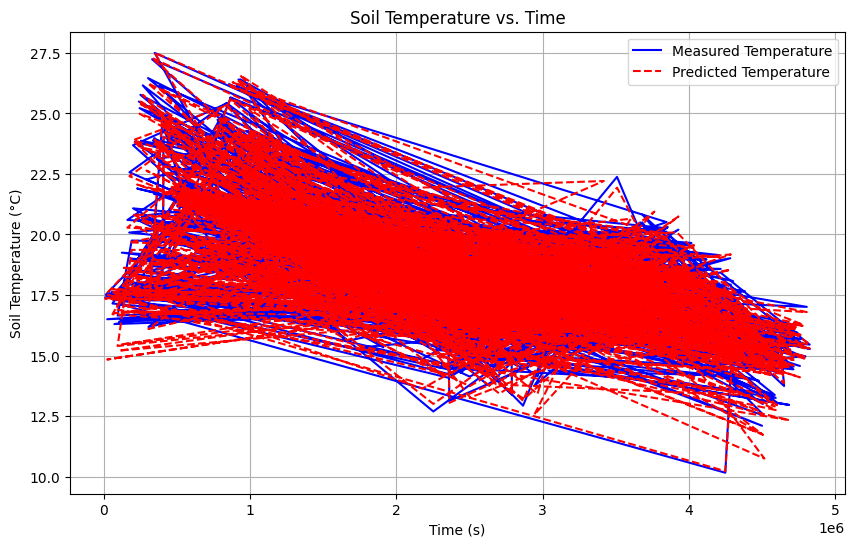

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(t_sampled, T_measured_sampled, 'b-', label='Measured Temperature')
plt.plot(t_sampled, T_pred_sampled, 'r--', label='Predicted Temperature')
plt.xlabel("Time (s)")
plt.ylabel("Soil Temperature (°C)")
plt.title("Soil Temperature vs. Time")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
model_test = heat_transfer_pinn.PINN(num_hidden_layers=4, num_neurons=64,
                                    t_mean=t_mean, t_std=t_std,
                                    z_mean=z_mean, z_std=z_std,
                                    theta_mean=theta_mean, theta_std=theta_std)
model_test.load_state_dict(torch.load("pinn_model_2_stage.pth"))
model_test.eval() 

PINN(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (activation): Tanh()
)

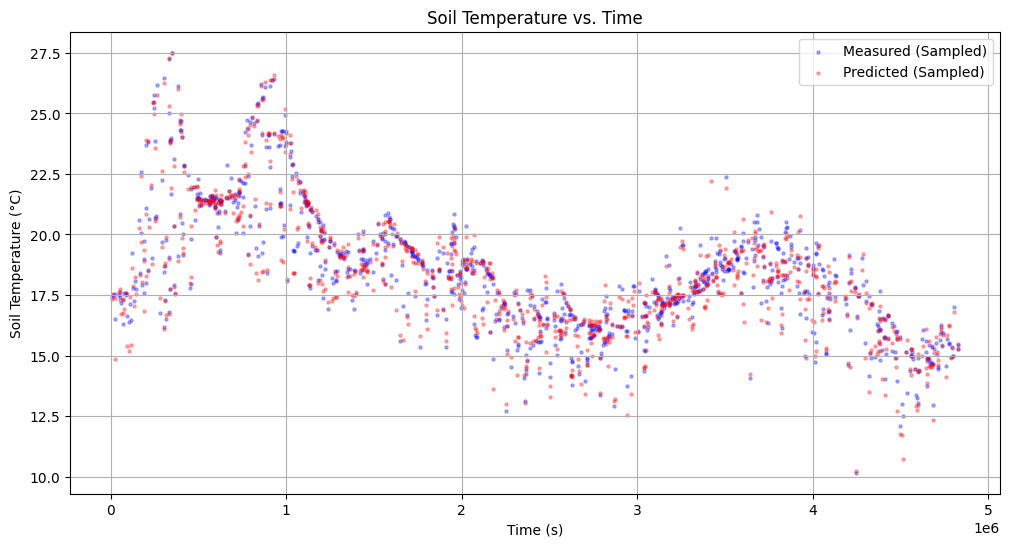

In [6]:
with torch.no_grad():
    T_pred_all = model_test(t_data_test, z_data_test, theta_data_test).squeeze().cpu().numpy()
    T_measured_all = T_measured_data_test.squeeze().cpu().numpy()
    t_all = t_data_test.squeeze().cpu().numpy()

# Downsample data to avoid overplotting
num_points = 1000  # Adjust based on how much detail you want
indices = np.linspace(0, len(t_all) - 1, num_points, dtype=int)

t_sampled = t_all[indices]
T_pred_sampled = T_pred_all[indices]
T_measured_sampled = T_measured_all[indices]


# -----------------------------
# Improved Time Series Plot
# -----------------------------
plt.figure(figsize=(12, 6))

# Plot the original raw data with transparency
plt.scatter(t_sampled, T_measured_sampled, color='blue', alpha=0.3, s=5, label='Measured (Sampled)')
plt.scatter(t_sampled, T_pred_sampled, color='red', alpha=0.3, s=5, label='Predicted (Sampled)')

plt.xlabel("Time (s)")
plt.ylabel("Soil Temperature (°C)")
plt.title("Soil Temperature vs. Time")
plt.legend()
plt.grid(True)
plt.show()